# TP1  &  TP2
#### Réalisé par : Mohamed Rida Lajghal  IID3

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

## TP1 : Logique Floue

### Exercice 1 : Distance_to_next_car

In [2]:
# Définir la variable floue
Distance_to_next_car = ctrl.Antecedent(np.arange(0, 30, 1), 'Distance_to_next_car')

In [3]:
# Créer les ensembles flous
Distance_to_next_car['v_small'] = fuzz.trimf(Distance_to_next_car.universe, [0, 0, 5])
Distance_to_next_car['small']   = fuzz.trapmf(Distance_to_next_car.universe, [0, 4, 8, 12])
Distance_to_next_car['perfect'] = fuzz.trapmf(Distance_to_next_car.universe, [8, 12, 18, 22])
Distance_to_next_car['big']     = fuzz.trapmf(Distance_to_next_car.universe, [18, 22, 26, 29])
Distance_to_next_car['v_big']   = fuzz.trimf(Distance_to_next_car.universe, [24, 29, 29])

c:\Users\redag\AppData\Local\Programs\Python\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


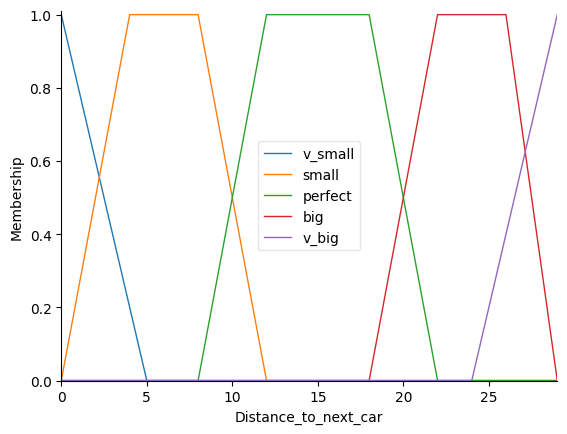

In [4]:
# Visualisation
Distance_to_next_car.view()

### Exercice 2 : Speed_change

In [5]:
Speed_change = ctrl.Antecedent(np.arange(-20, 20, 1), 'Speed_change')

Speed_change['declining'] = fuzz.trimf(Speed_change.universe, [-20, -20, 0])
Speed_change['constant']  = fuzz.trapmf(Speed_change.universe, [-10, -5, 5, 10])
Speed_change['growing']   = fuzz.trimf(Speed_change.universe, [0, 20, 20])

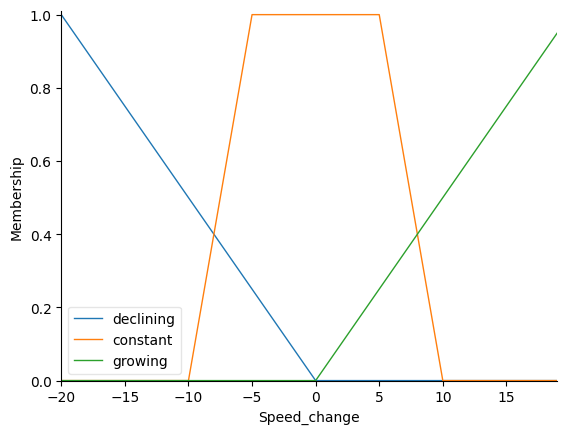

In [6]:
# Visualisation
Speed_change.view()

### Exercice 3 : Acceleration_Adjust

In [7]:
Acceleration_Adjust = ctrl.Consequent(np.arange(-3, 3.1, 0.5), 'Acceleration_Adjust')

Acceleration_Adjust['neg_big']   = fuzz.trimf(Acceleration_Adjust.universe, [-3, -3, -1.5])
Acceleration_Adjust['neg_small'] = fuzz.trimf(Acceleration_Adjust.universe, [-2.5, -1.5, -0.5])
Acceleration_Adjust['zero']      = fuzz.trimf(Acceleration_Adjust.universe, [-1, 0, 1])
Acceleration_Adjust['pos_small'] = fuzz.trimf(Acceleration_Adjust.universe, [0.5, 1.5, 2.5])
Acceleration_Adjust['pos_big']   = fuzz.trimf(Acceleration_Adjust.universe, [1.5, 3, 3])

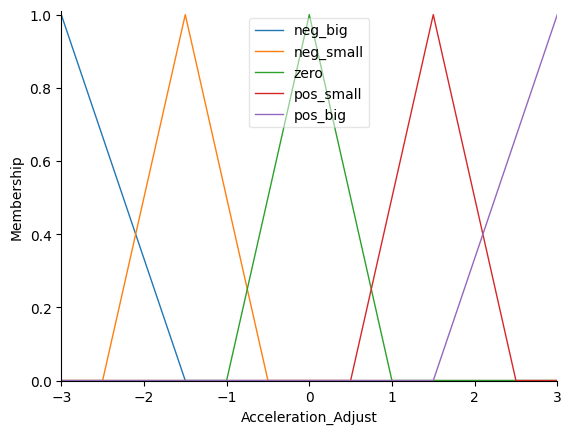

In [8]:
# Visualisation
Acceleration_Adjust.view()

### Exercice 4 : Règles floues et simulation

In [9]:
rules = [
    ctrl.Rule(Distance_to_next_car['v_small'] & Speed_change['declining'], Acceleration_Adjust['neg_small']),
    ctrl.Rule(Distance_to_next_car['v_small'] & Speed_change['constant'], Acceleration_Adjust['neg_big']),
    ctrl.Rule(Distance_to_next_car['v_small'] & Speed_change['growing'], Acceleration_Adjust['neg_big']),
    ctrl.Rule(Distance_to_next_car['small'] & Speed_change['declining'], Acceleration_Adjust['zero']),
    ctrl.Rule(Distance_to_next_car['small'] & Speed_change['constant'], Acceleration_Adjust['neg_small']),
    ctrl.Rule(Distance_to_next_car['small'] & Speed_change['growing'], Acceleration_Adjust['neg_big']),
    ctrl.Rule(Distance_to_next_car['perfect'] & Speed_change['declining'], Acceleration_Adjust['pos_small']),
    ctrl.Rule(Distance_to_next_car['perfect'] & Speed_change['constant'], Acceleration_Adjust['zero']),
    ctrl.Rule(Distance_to_next_car['perfect'] & Speed_change['growing'], Acceleration_Adjust['neg_small']),
    ctrl.Rule(Distance_to_next_car['big'] & Speed_change['declining'], Acceleration_Adjust['pos_big']),
    ctrl.Rule(Distance_to_next_car['big'] & Speed_change['constant'], Acceleration_Adjust['pos_small']),
    ctrl.Rule(Distance_to_next_car['big'] & Speed_change['growing'], Acceleration_Adjust['zero']),
    ctrl.Rule(Distance_to_next_car['v_big'] & Speed_change['declining'], Acceleration_Adjust['pos_big']),
    ctrl.Rule(Distance_to_next_car['v_big'] & Speed_change['constant'], Acceleration_Adjust['pos_big']),
    ctrl.Rule(Distance_to_next_car['v_big'] & Speed_change['growing'], Acceleration_Adjust['pos_small'])
]

In [10]:
# Créer le système de contrôle
Acceleration_Adjust_ctrl = ctrl.ControlSystem(rules)
simulator = ctrl.ControlSystemSimulation(Acceleration_Adjust_ctrl)

In [11]:
# Simulation pour Distance_to_next_car=13 et Speed_change=-2.5
simulator.input['Distance_to_next_car'] = 13
simulator.input['Speed_change'] = -2.5
simulator.compute()

In [12]:
print("Acceleration_Adjust estimée =", simulator.output['Acceleration_Adjust'])

Acceleration_Adjust estimée = 0.2738095238095238


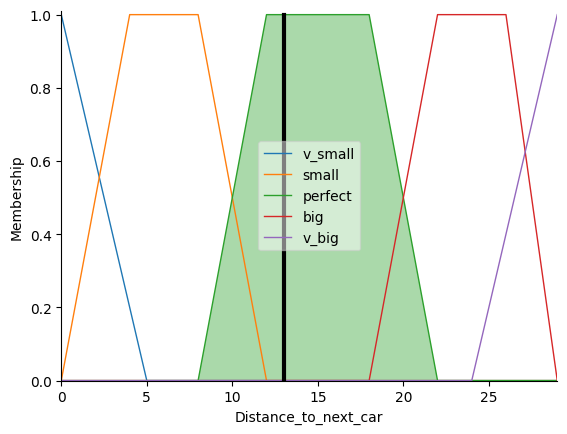

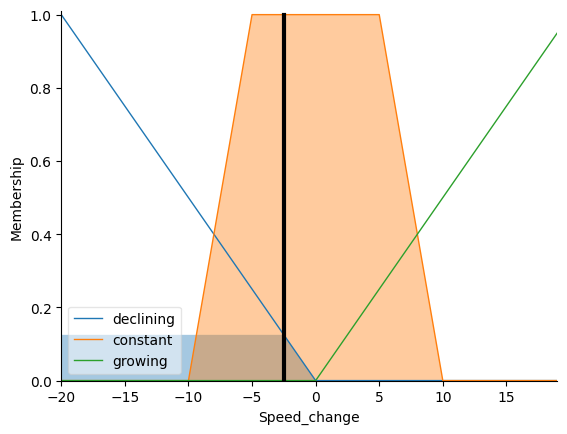

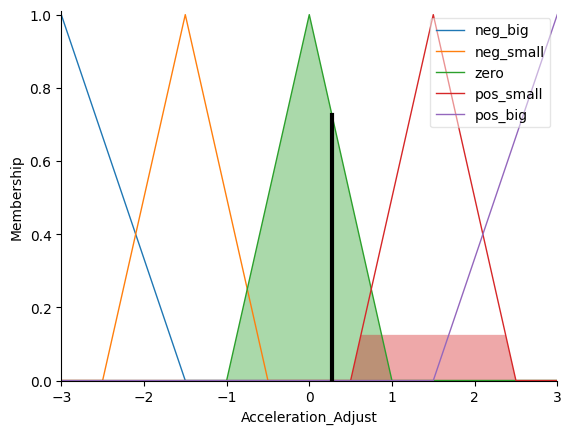

In [13]:
# Visualisation des effets
Distance_to_next_car.view(sim=simulator)
Speed_change.view(sim=simulator)
Acceleration_Adjust.view(sim=simulator)

## TP2 : Logique floue et intégration du ML

In [15]:
np.random.seed(42)
n_samples = 1000
dist_samples = np.random.uniform(0, 30, n_samples)
speed_samples = np.random.uniform(-20, 20, n_samples)

In [16]:
accel_outputs = []
for d, s in zip(dist_samples, speed_samples):
    simulator.input['Distance_to_next_car'] = float(d)
    simulator.input['Speed_change'] = float(s)
    simulator.compute()
    accel_outputs.append(float(simulator.output['Acceleration_Adjust']))

In [17]:
# Créer dataframe
df = pd.DataFrame({
    'Distance_to_next_car': dist_samples,
    'speed_change': speed_samples,
    'acceleration_adjust': accel_outputs
})

In [18]:
# Séparer train/test et entraîner RandomForest
X = df[['Distance_to_next_car', 'speed_change']].values
y = df['acceleration_adjust'].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [20]:
# Prédictions et évaluation
y_pred = model.predict(X_test)
print("MSE =", mean_squared_error(y_test, y_pred))
print("MAE =", mean_absolute_error(y_test, y_pred))

MSE = 0.004799368125702208
MAE = 0.039047372666946044


In [22]:
# Comparaison Fuzzy vs ML sur le test set
# Calculer les valeurs floues pour le test set
fuzzy_values = []
for d, s in zip(X_test[:, 0], X_test[:, 1]):
    simulator.input['Distance_to_next_car'] = float(d)
    simulator.input['Speed_change'] = float(s)
    simulator.compute()
    fuzzy_values.append(simulator.output['Acceleration_Adjust'])

# Créer un DataFrame comparatif
comparison_df = pd.DataFrame({
    'Distance_to_next_car': X_test[:, 0],
    'Speed_change': X_test[:, 1],
    'Accel_Fuzzy': fuzzy_values,
    'Accel_ML_Pred': y_pred
})

comparison_df.head()

,Distance_to_next_car,Speed_change,Accel_Fuzzy,Accel_ML_Pred
0,11.426726,17.377441,-1.609878,-1.605741
1,24.497983,-12.215100,2.445470,2.445855
2,13.880394,13.101516,-1.500000,-1.500000
3,10.682902,4.023773,-0.748893,-0.748948
4,28.501859,-15.523215,2.479530,2.476214


In [23]:
# Comparaison Fuzzy vs ML pour un exemple
d, s = 9.5, -3.0
simulator.input['Distance_to_next_car'] = d
simulator.input['Speed_change'] = s
simulator.compute()
accel_fuzzy = simulator.output['Acceleration_Adjust']
accel_model = model.predict(np.array([[d, s]]))[0]

print(f"Logique floue: {accel_fuzzy:.6f}")
print(f"ML RandomForest: {accel_model:.6f}")

Logique floue: -0.523131
ML RandomForest: -0.627187
